# Questions:
1) Is the low-resolution data meant to have the same number of grid points as the high-resolution data?
2) If not, how do I create a low-resolution dataset with fewer grid points?
3) What is the filtering scale used for CM2.6?

**Note: The relevant code is under the "Filtering with gcm-filters attempt" section**

# Prepping data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
    
print("Load Data")
ocean_path = "gs://cmip6/GFDL_CM2_6/control/surface"
ds_ocean = xr.open_dataset(fs.get_mapper(ocean_path), chunks={"time": 3}, **kwargs)

ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds_ocean_boundary = xr.open_dataset(fs.get_mapper(ocean_boundary_path), chunks={"time": 3}, **kwargs)

grid_path = "gs://cmip6/GFDL_CM2_6/grid"
ds_ocean_grid = xr.open_dataset(fs.get_mapper(grid_path), chunks={}, **kwargs)

# combine all dataset on the ocean grid together
ds_ocean = xr.merge([ds_ocean_grid, ds_ocean, ds_ocean_boundary], compat='override')
ds_ocean

print("Interpolating ocean velocities")
# interpolate ocean velocities onto the tracer points using xgcm
from xgcm import Grid

# add xgcm comodo attrs
ds_ocean["xu_ocean"].attrs["axis"] = "X"
ds_ocean["xt_ocean"].attrs["axis"] = "X"
ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
ds_ocean["yu_ocean"].attrs["axis"] = "Y"
ds_ocean["yt_ocean"].attrs["axis"] = "Y"
ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
grid = Grid(ds_ocean)

# fill missing values with 0, then interpolate.
tracer_ref = ds_ocean["surface_temp"]
sst_wet_mask = ~np.isnan(tracer_ref)

ds_ocean["u_ocean"] = grid.interp_like(
    ds_ocean["usurf"].fillna(0), tracer_ref
).where(sst_wet_mask)
ds_ocean["v_ocean"] = grid.interp_like(
    ds_ocean["vsurf"].fillna(0), tracer_ref
).where(sst_wet_mask)

Load Data
Interpolating ocean velocities


In [3]:
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
atmos_path = "gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr"
ds_atmos = xr.open_dataset(fs.get_mapper(atmos_path), chunks={"time": 120}, **kwargs).chunk(
    {"time": 3}
)

# rename the atmos data coordinates only to CESM conventions
ds_atmos = ds_atmos.rename({'grid_xt':'lon', 'grid_yt':'lat'})

print("Modify units")
ds_ocean["surface_temp"] = ds_ocean["surface_temp"] + 273.15
ds_atmos["slp"] = ds_atmos["slp"] * 100  # TODO: Double check this
ds_atmos

Modify units


<xarray.Dataset> Size: 1TB
Dimensions:       (time: 29586, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * lon           (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * lat           (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 237kB 0120-01-01 12:00:00 ... 0200-12-31 12:0...
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T1    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T2    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    evap          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (lon, bnds) float64 9kB dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v700          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v850          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v_ref         (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind_max      (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

# Merge ocean and atmos data

In [4]:
def load_and_combine_cm26(
    filesystem: gcsfs.GCSFileSystem, inline_array=False
) -> xr.Dataset:
    """Loads, combines, and preprocesses CM2.6 data
    Steps:
    - Interpolate ocean velocities on ocean tracer points (with xgcm)
    - Regrid atmospheric variables to ocean tracer grid (with xesmf)
    - Match time and merge datasets
    - Adjust units for aerobulk input
    - Calculate relative wind components
    """
    kwargs = dict(
        consolidated=True, use_cftime=True, inline_array=inline_array, engine="zarr"
    )
    print("Load Data")
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/surface")
    ds_ocean = xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean_boundary")
    xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)

    # xarray says not to do this
    # ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr")
    ds_atmos = xr.open_dataset(mapper, chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
    ds_oc_grid = xr.open_dataset(mapper, chunks={}, **kwargs)
    # ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

    print("Align in time")
    # cut to same time
    all_dims = set(list(ds_ocean.dims) + list(ds_atmos.dims))
    ds_ocean, ds_atmos = xr.align(
        ds_ocean,
        ds_atmos,
        join="inner",
        exclude=(di for di in all_dims if di != "time"),
    )

    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    from xgcm import Grid

    # add xgcm comodo attrs
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)
    # fill missing values with 0, then interpolate.
    sst_wet_mask = ~np.isnan(ds_ocean["surface_temp"])
    # TODO: Maybe stencil out the nans from SST? This is done again in aerobulk-python
    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    # FIXME: All of these additional operations (filling/masking) add lot more tasks...

    print("Regrid Atmospheric Data")
    # Start regridding the atmosphere onto the ocean grid
    # Load precalculated regridder weights from group bucket
    # TODO: Maybe this should be an input argument?
    path = "gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr"  # noqa: E501
    mapper = filesystem.get_mapper(path)
    ds_regridder = xr.open_zarr(mapper).load()
    regridder = xe.Regridder(
        ds_atmos.olr.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),  # this is the same dumb problem I keep having with
        ds_ocean.surface_temp.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),
        "bilinear",
        weights=ds_regridder,
        periodic=True,
    )
    ds_atmos_regridded = regridder(
        ds_atmos[["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind"]]
    )  # We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'

    ## combine into merged dataset
    ds_merged = xr.merge(
        [
            ds_atmos_regridded,
            ds_ocean[["surface_temp", "u_ocean", "v_ocean"]],
        ]
    )
    print("Modify units")
    # ds_merged = ds_merged.transpose(
    #     'xt_ocean', 'yt_ocean', 'time'
    # )
    # fix units for aerobulk
    ds_merged["surface_temp"] = ds_merged["surface_temp"] + 273.15
    ds_merged["slp"] = ds_merged["slp"] * 100  # check this

    print("Mask nans")
    # atmos missing values are filled with 0s, which causes issues with the filtering
    # Ideally this should be masked before the regridding, but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged['surface_temp'].isel(time=0).reset_coords(drop=True))
    for mask_var in ['slp', 't_ref', 'q_ref', 'v_ref', 'u_ref', 'wind']:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)
    
    
    # also apply this mask to certain coordinates from the grid dataset (for now only tracer_area since that 
    for mask_coord in ['area_t']:
        ds_merged.coords[mask_coord] = ds_oc_grid[mask_coord].where(mask,0.0).astype(np.float64)
    # The casting to float64 is needed to avoid that weird bug where the manual global weighted ave
    # is not close to the xarray weighted mean (I was not able to reproduce this with an example)
    
    # Ideally this should be masked before the regridding,
    # but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged["surface_temp"])
    for mask_var in ["slp", "t_ref", "q_ref"]:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)

    # Calculate relative wind
    print("Calculate relative wind")
    ds_merged["u_relative"] = ds_merged["u_ref"] - ds_merged["u_ocean"]
    ds_merged["v_relative"] = ds_merged["v_ref"] - ds_merged["v_ocean"]

    return ds_merged

In [5]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# GCM Filtering -- some useful functions

In [6]:
#IMPORTANT FUNCS

#from scale_aware_air_sea.parameters import get_params
#from scale_aware_air_sea.stages import preprocess
#from scale_aware_air_sea.stages_tests import test_data_preprocessing, test_smoothed_data, test_data_flux
#from scale_aware_air_sea.utils import weighted_coarsen, filter_inputs_dataset, to_zarr_split

import gcsfs
import gcm_filters

In [7]:
def filter_inputs_dataset(
    ds: xr.Dataset,
    dims: list,
    filter_scale: int,
    timedim: str = "time",
    filter_type: str = "taper",
) -> xr.Dataset:
    """Wrapper that filters a whole dataset, generating a wet_mask from
    the nanmask of the first timestep (if time is present)."""
    ds_out = xr.Dataset()

    # create a wet mask that only allows values which are 'wet' in all variables

    wet_masks = []
    for var in ds.data_vars:
        da = ds[var]
        if timedim in da.dims:
            mask_da = da.isel({timedim: 0})
        else:
            mask_da = da
        wet_masks.append((~np.isnan(mask_da)))

    combined_wet_mask = xr.concat(wet_masks, dim="var").all("var").astype(int)

    for var in ds.data_vars:
        ds_out[var] = filter_inputs(
            ds[var], combined_wet_mask, dims, filter_scale, filter_type=filter_type
        )

    ds_out.attrs["filter_scale"] = filter_scale
    ds_out.attrs["filter_type"] = filter_type
    return ds_out

In [8]:
def filter_inputs(
    da: xr.DataArray,
    wet_mask: xr.DataArray,
    dims: list,
    filter_scale: int,
    filter_type: str = "taper",
) -> xr.DataArray:
    """filters input using gcm-filters"""
    if filter_type == "gaussian":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "taper":
        # transition_width = np.pi/2
        transition_width = np.pi
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            transition_width=transition_width,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.TAPER,
            grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
            grid_vars={"wet_mask": wet_mask},
        )
    elif filter_type == "tripolar_pop":
        input_filter = gcm_filters.Filter(
            filter_scale=filter_scale,
            dx_min=1,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
            grid_vars={"area":da.TAREA,"wet_mask": wet_mask},
        )

    else:
        raise ValueError(
            f"`filter_type` needs to be `gaussian` or `taper', got {filter_type}"
        )
    out = input_filter.apply(da, dims=dims)
    out.attrs["filter_scale"] = filter_scale
    out.attrs["filter_type"] = filter_type
    return out


# Filtering with gcm-filters Attempt

In [9]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_in

<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

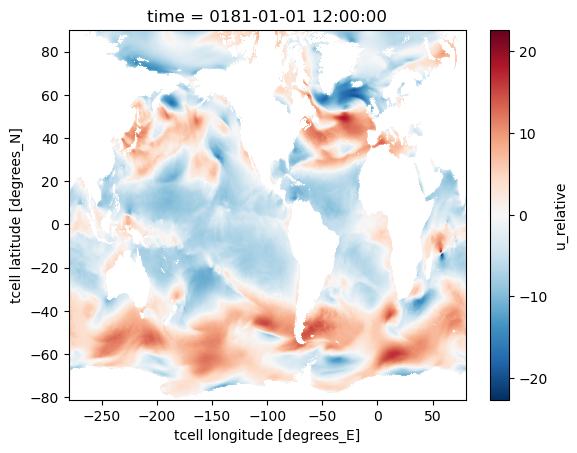

In [19]:
ds_in.u_relative.isel(time=0).plot()

In [11]:
print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=4, filter_type='taper')
ds_out

Filtering model


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  4
    filter_type:   taper

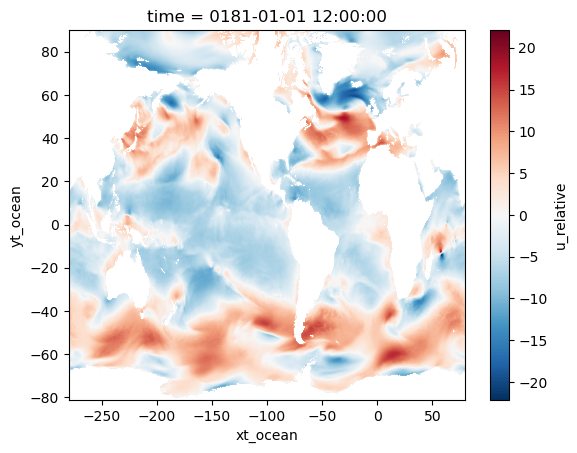

In [12]:
ds_out.u_relative.isel(time=0).plot()

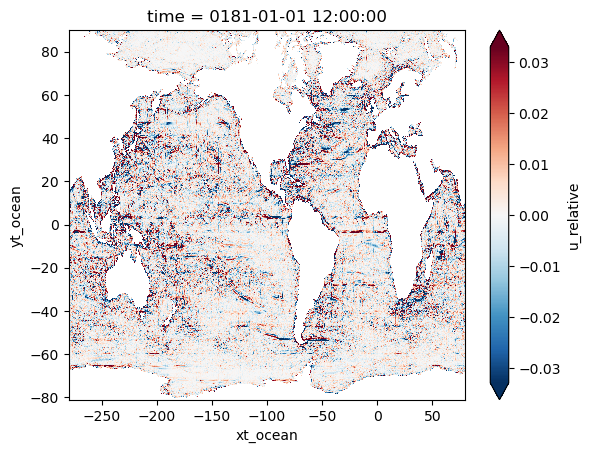

In [14]:
u_diff = ds_in.u_relative.isel(time=0) - ds_out.u_relative.isel(time=0)
u_diff.plot(robust=True)